In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

In [1]:
import h5py
import os

# Path to your PRISMA .he5 file
file = "/home/daljit/hyperspec_project/data/PRS_L1_STD_OFFL_20201229101250_20201229101254_0001.he5"

print("File exists:", os.path.exists(file))

with h5py.File(file, "r") as f:
    print("\nTop-level groups:")
    for key in f.keys():
        print(" -", key)

    print("\nAll datasets inside file:\n")

    def show(name, obj):
        if isinstance(obj, h5py.Dataset):
            print("Dataset:", name, "→ shape:", obj.shape)

    f.visititems(show)


File exists: True

Top-level groups:
 - HDFEOS
 - HDFEOS INFORMATION
 - Info
 - KDP_AUX

All datasets inside file:

Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/Cloud_Mask → shape: (1000, 1000)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/FrameNumber → shape: (1000,)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/LandCover_Mask → shape: (1000, 1000)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/SWIR_Cube → shape: (1000, 173, 1000)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/SWIR_PIXEL_SAT_ERR_MATRIX → shape: (1000, 173, 1000)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/SunGlint_Mask → shape: (1000, 1000)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/VNIR_Cube → shape: (1000, 66, 1000)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/VNIR_PIXEL_SAT_ERR_MATRIX → shape: (1000, 66, 1000)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Geolocation Fields/Latitude_SWIR → shape: (1000, 1000)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Geolocation Fields/Latitude_VNIR → shape: (1000, 1000)
Dataset: HDFEOS/SWATHS/PR

VNIR shape: (1000, 66, 1000)
SWIR shape: (1000, 173, 1000)
Latitude shape: (1000, 1000)
Longitude shape: (1000, 1000)


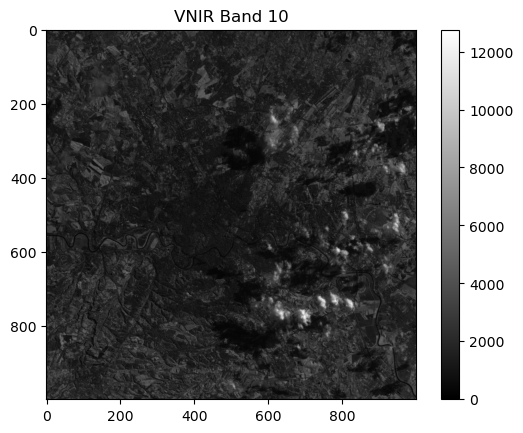

In [2]:
# extract_prisma
import h5py
import numpy as np
import matplotlib.pyplot as plt

file = "/home/daljit/hyperspec_project/data/PRS_L1_STD_OFFL_20201229101250_20201229101254_0001.he5"

with h5py.File(file, "r") as f:

    # VNIR cube (1000, 66, 1000)
    vnir = f["HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/VNIR_Cube"][:]
    print("VNIR shape:", vnir.shape)

    # SWIR cube (1000, 173, 1000)
    swir = f["HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/SWIR_Cube"][:]
    print("SWIR shape:", swir.shape)

    # Geolocation
    lat = f["HDFEOS/SWATHS/PRS_L1_HCO/Geolocation Fields/Latitude_VNIR"][:]
    lon = f["HDFEOS/SWATHS/PRS_L1_HCO/Geolocation Fields/Longitude_VNIR"][:]

    print("Latitude shape:", lat.shape)
    print("Longitude shape:", lon.shape)

# Show VNIR band 10
plt.imshow(vnir[:, 10, :], cmap="gray")
plt.title("VNIR Band 10")
plt.colorbar()
plt.show()



In [3]:
# combine_cube : Rearrange the axes, merges them into one big cube
import h5py
import numpy as np

# Path to your file
file = "/home/daljit/hyperspec_project/data/PRS_L1_STD_OFFL_20201229101250_20201229101254_0001.he5"

print("Loading data...")

with h5py.File(file, "r") as f:

    # Load VNIR (1000 x 66 x 1000)
    vnir = f["HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/VNIR_Cube"][:]
    print("VNIR:", vnir.shape)

    # Load SWIR (1000 x 173 x 1000)
    swir = f["HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/SWIR_Cube"][:]
    print("SWIR:", swir.shape)

# IMPORTANT: Move the band axis to the END
# Current:   rows, bands, cols
# Required:  rows, cols, bands

vnir = np.transpose(vnir, (0, 2, 1))
swir = np.transpose(swir, (0, 2, 1))

print("VNIR reordered:", vnir.shape)
print("SWIR reordered:", swir.shape)

# Now stack them along the last axis (bands)
full_cube = np.concatenate((vnir, swir), axis=2)

print("Full cube shape:", full_cube.shape)

# Save combined cube as .npy (fast and safe)
np.save("/home/daljit/hyperspec_project/full_cube.npy", full_cube)

print("Saved full hyperspectral cube as full_cube.npy")


Loading data...
VNIR: (1000, 66, 1000)
SWIR: (1000, 173, 1000)
VNIR reordered: (1000, 1000, 66)
SWIR reordered: (1000, 1000, 173)
Full cube shape: (1000, 1000, 239)
Saved full hyperspectral cube as full_cube.npy


Original cube shape: (1000, 1000, 239)
Noise added and saved as noisy_cube.npy
Original mean: 940.2321
Noisy mean: 944.2490116105874


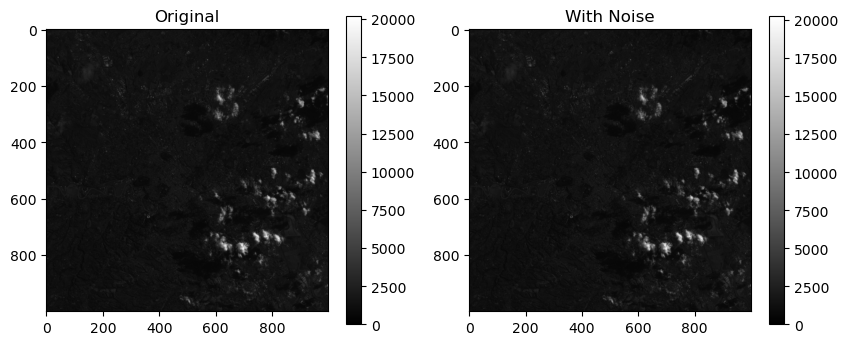

In [1]:
# add noise for testing
import numpy as np
import matplotlib.pyplot as plt

# 1. Load your corrected cube (or full_cube)
cube = np.load("/home/daljit/hyperspec_project/full_cube.npy")
print("Original cube shape:", cube.shape)

# 2. Convert to float (important for noise math)
cube = cube.astype(np.float32)

# 3. Define noise level
noise_std = 0.05 * np.mean(cube)  
# 5% of mean signal → realistic noise

# 4. Generate Gaussian noise
noise = np.random.normal(
    loc=0.0,
    scale=noise_std,
    size=cube.shape
)

# 5. Add noise
noisy_cube = cube + noise

# 6. Avoid negative values
noisy_cube[noisy_cube < 0] = 0

# 7. Save noisy cube
np.save("/home/daljit/hyperspec_project/noisy_cube.npy", noisy_cube)

print("Noise added and saved as noisy_cube.npy")
print("Original mean:", cube.mean())
print("Noisy mean:", noisy_cube.mean())


band = 30  # any band

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(cube[:,:,band], cmap="gray")
plt.colorbar()

plt.subplot(1,2,2)
plt.title("With Noise")
plt.imshow(noisy_cube[:,:,band], cmap="gray")
plt.colorbar()

plt.show()

In [2]:
# pca_denoise

import numpy as np
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt

# Load cube
cube = np.load("/home/daljit/hyperspec_project/noisy_cube.npy")
h, w, b = cube.shape
print("Cube:", cube.shape)

# Output array
denoised = np.zeros_like(cube)

# Tile size (SAFE)
tile = 200
components = 20

for i in range(0, h, tile):
    for j in range(0, w, tile):

        print(f"Processing tile ({i}:{i+tile}, {j}:{j+tile})")

        block = cube[i:i+tile, j:j+tile, :]
        bh, bw, bb = block.shape

        # reshape tile only
        X = block.reshape(-1, bb)

        ipca = IncrementalPCA(n_components=components, batch_size=500)
        ipca.fit(X)

        Xr = ipca.inverse_transform(ipca.transform(X))
        denoised[i:i+bh, j:j+bw, :] = Xr.reshape(bh, bw, bb)

# Save result
np.save("/home/daljit/hyperspec_project/pca_denoised.npy", denoised)
print("PCA tile denoising completed!")


Cube: (1000, 1000, 239)
Processing tile (0:200, 0:200)
Processing tile (0:200, 200:400)
Processing tile (0:200, 400:600)
Processing tile (0:200, 600:800)
Processing tile (0:200, 800:1000)
Processing tile (200:400, 0:200)
Processing tile (200:400, 200:400)
Processing tile (200:400, 400:600)
Processing tile (200:400, 600:800)
Processing tile (200:400, 800:1000)
Processing tile (400:600, 0:200)
Processing tile (400:600, 200:400)
Processing tile (400:600, 400:600)
Processing tile (400:600, 600:800)
Processing tile (400:600, 800:1000)
Processing tile (600:800, 0:200)
Processing tile (600:800, 200:400)
Processing tile (600:800, 400:600)
Processing tile (600:800, 600:800)
Processing tile (600:800, 800:1000)
Processing tile (800:1000, 0:200)
Processing tile (800:1000, 200:400)
Processing tile (800:1000, 400:600)
Processing tile (800:1000, 600:800)
Processing tile (800:1000, 800:1000)
PCA tile denoising completed!


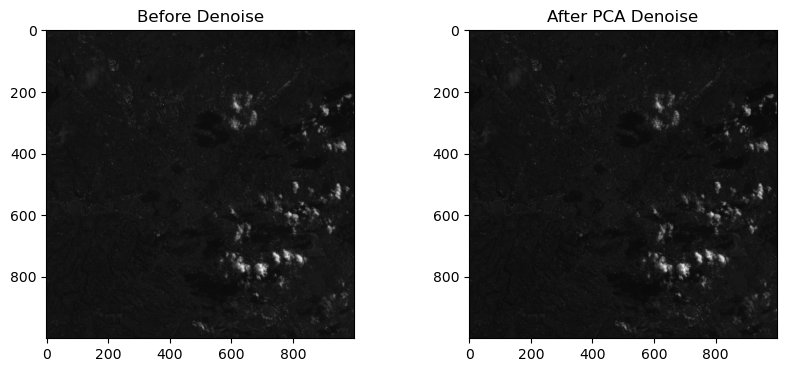

In [3]:

orig = np.load("noisy_cube.npy")
den = np.load("pca_denoised.npy")

band = 40

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Before Denoise")
plt.imshow(orig[:,:,band], cmap="gray")

plt.subplot(1,2,2)
plt.title("After PCA Denoise")
plt.imshow(den[:,:,band], cmap="gray")
plt.show()

In [1]:
# Geometric Correction : Affine transformation

import numpy as np

cube = np.load("/home/daljit/hyperspec_project/full_cube.npy")
lat = np.load("/home/daljit/hyperspec_project/lat.npy")
lon = np.load("/home/daljit/hyperspec_project/lon.npy")

dlat = np.mean(np.abs(np.diff(lat, axis=0)))
dlon = np.mean(np.abs(np.diff(lon, axis=1)))

print("Cube:", cube.shape)
print("Latitude:", lat.shape)
print("Longitude:", lon.shape)

print("Latitude pixel resolution:", dlat)
print("Longitude pixel resolution:", dlon)


Cube: (1000, 1000, 239)
Latitude: (1000, 1000)
Longitude: (1000, 1000)
Latitude pixel resolution: 6.571493e-05
Longitude pixel resolution: 8.051752e-05


In [2]:
# Geotiff of Affine
from osgeo import gdal, osr
import numpy as np

# === Load data ===
cube = np.load("/home/daljit/hyperspec_project/full_cube.npy")
lat = np.load("/home/daljit/hyperspec_project/lat.npy")
lon = np.load("/home/daljit/hyperspec_project/lon.npy")

# === Pixel resolution (from your result) ===
dlat = 6.571493e-05
dlon = 8.051752e-05

# === Upper-left corner ===
lat_ul = lat[0, 0]
lon_ul = lon[0, 0]

# === Create transform ===
geotransform = (lon_ul, dlon, 0, lat_ul, 0, -dlat)

print("GeoTransform:", geotransform)

# === Create GeoTIFF ===
bands = cube.shape[2]
rows, cols = cube.shape[0], cube.shape[1]

driver = gdal.GetDriverByName("GTiff")
output = driver.Create(
    "/home/daljit/hyperspec_project/geocorrected.tif",
    cols, rows, bands, gdal.GDT_Float32
)

output.SetGeoTransform(geotransform)

# === Set projection to WGS84 ===
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)
output.SetProjection(srs.ExportToWkt())

# === Write bands ===
for b in range(bands):
    output.GetRasterBand(b + 1).WriteArray(cube[:, :, b])

output.FlushCache()
print("Saved geocorrected.tif successfully!")


GeoTransform: (np.float32(12.719669), 8.051752e-05, 0, np.float32(41.986233), 0, -6.571493e-05)


/home/daljit/miniconda3/envs/hypenv/lib/python3.11/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Saved geocorrected.tif successfully!


In [1]:
# Atmospheric Correction 
import numpy as np

# Load hyperspectral radiance cube
cube = np.load("/home/daljit/hyperspec_project/full_cube.npy")
rows, cols, bands = cube.shape

# Output cube
quac = np.zeros_like(cube, dtype=np.float32)

print("Starting QUAC atmospheric correction...")

for b in range(bands):
    band = cube[:, :, b]

    # 1. Flatten to 1D to sort pixels
    flat = band.flatten()

    # 2. Pick darkest 1% pixels
    dark_count = max(1, int(len(flat) * 0.01))  # avoid 0
    dark_pixels = np.sort(flat)[:dark_count]

    # 3. Compute mean of dark pixels
    dark_mean = np.mean(dark_pixels)

    # Avoid division by zero
    if dark_mean < 1e-6:
        dark_mean = 1e-6

    # 4. Normalize to create reflectance
    quac[:, :, b] = band / dark_mean

    print(f"Band {b+1}/{bands} corrected")

# Save result
np.save("/home/daljit/hyperspec_project/quac_reflectance.npy", quac)

print("QUAC correction completed!")



Starting QUAC atmospheric correction...
Band 1/239 corrected
Band 2/239 corrected
Band 3/239 corrected
Band 4/239 corrected
Band 5/239 corrected
Band 6/239 corrected
Band 7/239 corrected
Band 8/239 corrected
Band 9/239 corrected
Band 10/239 corrected
Band 11/239 corrected
Band 12/239 corrected
Band 13/239 corrected
Band 14/239 corrected
Band 15/239 corrected
Band 16/239 corrected
Band 17/239 corrected
Band 18/239 corrected
Band 19/239 corrected
Band 20/239 corrected
Band 21/239 corrected
Band 22/239 corrected
Band 23/239 corrected
Band 24/239 corrected
Band 25/239 corrected
Band 26/239 corrected
Band 27/239 corrected
Band 28/239 corrected
Band 29/239 corrected
Band 30/239 corrected
Band 31/239 corrected
Band 32/239 corrected
Band 33/239 corrected
Band 34/239 corrected
Band 35/239 corrected
Band 36/239 corrected
Band 37/239 corrected
Band 38/239 corrected
Band 39/239 corrected
Band 40/239 corrected
Band 41/239 corrected
Band 42/239 corrected
Band 43/239 corrected
Band 44/239 corrected
B

In [2]:
# Quac Geotiff
import numpy as np
from osgeo import gdal, osr

# === 1. Load corrected cube ===
cube = np.load("/home/daljit/hyperspec_project/quac_reflectance.npy")

# cube shape = (rows, cols, 239 bands)
rows, cols, bands = cube.shape

# === 2. Load georeferencing from your earlier data ===
# We use same geotransform as geometric correction step
gt = (12.719669, 8.051752e-05, 0,
      41.986233, 0, -6.571493e-05)

# === 3. Create GeoTIFF ===
driver = gdal.GetDriverByName("GTiff")
out_tif = "/home/daljit/hyperspec_project/quac_corrected.tif"

ds = driver.Create(out_tif, cols, rows, bands, gdal.GDT_Float32)

# Set correct GeoTransform
ds.SetGeoTransform(gt)

# === 4. Assign WGS84 coordinate system ===
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)       # WGS 84
ds.SetProjection(srs.ExportToWkt())

# === 5. Write each band into TIFF ===
for i in range(bands):
    band = ds.GetRasterBand(i+1)
    band.WriteArray(cube[:, :, i])
    print(f"Band {i+1}/{bands} written")

# Close file
ds = None
print("Saved quac_corrected.tif successfully!")


/home/daljit/miniconda3/envs/hypenv/lib/python3.11/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Band 1/239 written
Band 2/239 written
Band 3/239 written
Band 4/239 written
Band 5/239 written
Band 6/239 written
Band 7/239 written
Band 8/239 written
Band 9/239 written
Band 10/239 written
Band 11/239 written
Band 12/239 written
Band 13/239 written
Band 14/239 written
Band 15/239 written
Band 16/239 written
Band 17/239 written
Band 18/239 written
Band 19/239 written
Band 20/239 written
Band 21/239 written
Band 22/239 written
Band 23/239 written
Band 24/239 written
Band 25/239 written
Band 26/239 written
Band 27/239 written
Band 28/239 written
Band 29/239 written
Band 30/239 written
Band 31/239 written
Band 32/239 written
Band 33/239 written
Band 34/239 written
Band 35/239 written
Band 36/239 written
Band 37/239 written
Band 38/239 written
Band 39/239 written
Band 40/239 written
Band 41/239 written
Band 42/239 written
Band 43/239 written
Band 44/239 written
Band 45/239 written
Band 46/239 written
Band 47/239 written
Band 48/239 written
Band 49/239 written
Band 50/239 written
Band 51/2

Cube: (1000, 1000, 239)
Wavelengths: (239,)
Selected bands:
Red: 662.7692307692307 index = 28
Green: 559.5384615384615 index = 17
Blue: 484.46153846153845 index = 9
RGB image saved as rgb_image.png


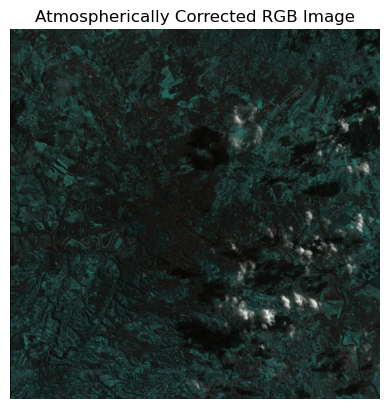

In [3]:
# rgb image
import numpy as np
import matplotlib.pyplot as plt

# === Load corrected data ===
cube = np.load("/home/daljit/hyperspec_project/quac_reflectance.npy")
wl = np.load("/home/daljit/hyperspec_project/wavelengths_fixed.npy")

print("Cube:", cube.shape)
print("Wavelengths:", wl.shape)

# === Define RGB target wavelengths ===
target_R = 660   # nm
target_G = 560
target_B = 480

# === Find closest bands ===
idx_R = np.argmin(np.abs(wl - target_R))
idx_G = np.argmin(np.abs(wl - target_G))
idx_B = np.argmin(np.abs(wl - target_B))

print("Selected bands:")
print("Red:", wl[idx_R], "index =", idx_R)
print("Green:", wl[idx_G], "index =", idx_G)
print("Blue:", wl[idx_B], "index =", idx_B)

# === Extract RGB channels ===
R = cube[:, :, idx_R]
G = cube[:, :, idx_G]
B = cube[:, :, idx_B]

# === Normalize channels ===
def norm(x):
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

R = norm(R)
G = norm(G)
B = norm(B)

# === Stack into RGB ===
rgb = np.dstack([R, G, B])

# === Display ===
plt.imshow(rgb)
plt.title("Atmospherically Corrected RGB Image")
plt.axis("off")

# Save image
plt.savefig("/home/daljit/hyperspec_project/rgb_image.png", dpi=300, bbox_inches="tight")

print("RGB image saved as rgb_image.png")


In [4]:
# Cloud Mask
import numpy as np

# Load QUAC-corrected cube
cube = np.load(
    "/home/daljit/hyperspec_project/quac_reflectance.npy",
    mmap_mode="r+"
)

print("Cube shape:", cube.shape)

# Use a VNIR band (green ~560 nm)
green_band = cube[:,:,17]   # band index 17 ≈ 560 nm

# Define cloud threshold (bright pixels)
threshold = np.percentile(green_band, 98)

print("Cloud threshold:", threshold)

# Create cloud mask
cloud_mask = green_band > threshold

# Apply mask to ALL bands
cube[cloud_mask, :] = np.nan

# Save masked cube
np.save("/home/daljit/hyperspec_project/quac_cloudmasked.npy", cube)

print("Cloud-masked cube saved")


Cube shape: (1000, 1000, 239)
Cloud threshold: 11.136008
Cloud-masked cube saved


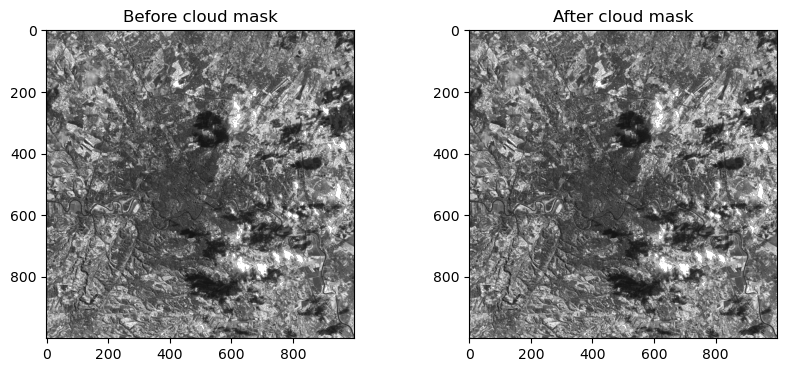

In [5]:
# Check cloud mask
import numpy as np
import matplotlib.pyplot as plt

orig = np.load("/home/daljit/hyperspec_project/quac_reflectance.npy")
masked = np.load("/home/daljit/hyperspec_project/quac_cloudmasked.npy")

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(orig[:,:,17], cmap="gray")
plt.title("Before cloud mask")

plt.subplot(1,2,2)
plt.imshow(masked[:,:,17], cmap="gray")
plt.title("After cloud mask")

plt.show()


Cube shape: (1000, 1000, 239)
Subset shape: (22363, 239)
Noise covariance shape: (239, 239)
First 10 eigenvalues:
[7.24176821e+14 1.66520711e+14 1.02362999e+14 9.71624050e+13
 8.68095595e+13 7.92605202e+13 7.27884453e+13 6.52491503e+13
 6.06851244e+13 5.87155558e+13]


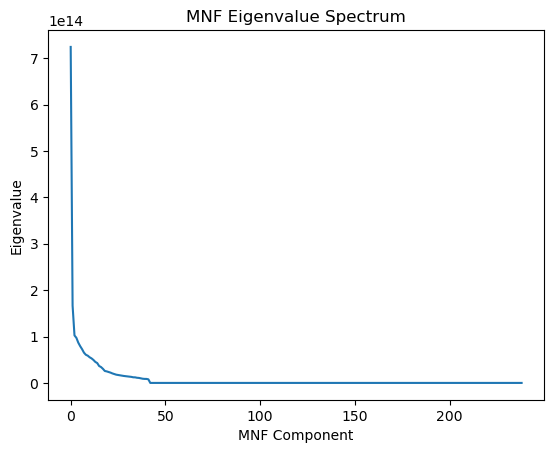

In [6]:
# MNF
import numpy as np
import matplotlib.pyplot as plt

cube = np.load(
    "/home/daljit/hyperspec_project/quac_cloudmasked.npy",
    mmap_mode="r"
)

print("Cube shape:", cube.shape)

# step 2
# Small spatial window
subset = cube[200:350, 200:350, :]

# Remove cloud pixels (NaN)
subset = subset[~np.isnan(subset).any(axis=2)]

print("Subset shape:", subset.shape)

# step 3
# Difference between adjacent pixels
noise = subset[1:,:] - subset[:-1,:]

# Noise covariance matrix
noise_cov = np.cov(noise, rowvar=False)

print("Noise covariance shape:", noise_cov.shape)

# step 4
# Eigen-decomposition
eigvals, eigvecs = np.linalg.eigh(noise_cov)

# Sort descending
idx = eigvals.argsort()[::-1]
eigvals = eigvals[idx]

print("First 10 eigenvalues:")
print(eigvals[:10])

# Plot eigenvalues
plt.plot(eigvals)
plt.xlabel("MNF Component")
plt.ylabel("Eigenvalue")
plt.title("MNF Eigenvalue Spectrum")
plt.show()

In [1]:
# MNF Apply
import numpy as np
from sklearn.decomposition import PCA


# 1. Load QUAC corrected cube

cube = np.load("/home/daljit/hyperspec_project/quac_reflectance.npy")
rows, cols, bands = cube.shape
print("Cube:", cube.shape)


# 2. Reshape to pixels × bands

X = cube.reshape(-1, bands)


# 3. RANDOM SUBSAMPLING (CRITICAL)

np.random.seed(42)
sample_size = 20000        # SAFE number (can increase later)
idx = np.random.choice(X.shape[0], sample_size, replace=False)
X_sample = X[idx]


# 4. Estimate noise

noise = X_sample[1:] - X_sample[:-1]

# Remove NaNs
noise = noise[~np.isnan(noise).any(axis=1)]
X_sample = np.nan_to_num(X_sample, nan=0.0)

print("Sample used for MNF:", X_sample.shape)


# 5. Noise whitening PCA

noise_pca = PCA(
    whiten=True,
    svd_solver="randomized",
    random_state=42
)
noise_pca.fit(noise)


# 6. Apply whitening to FULL image

X_clean = np.nan_to_num(X, nan=0.0)
X_whitened = noise_pca.transform(X_clean)


# 7. Signal PCA (MNF)

mnf_components = 30
signal_pca = PCA(
    n_components=mnf_components,
    svd_solver="randomized",
    random_state=42
)
signal_pca.fit(X_sample)

X_mnf = signal_pca.transform(X_whitened)


# 8. Reshape back

mnf_cube = X_mnf.reshape(rows, cols, mnf_components)


# 9. Save

np.save("/home/daljit/hyperspec_project/mnf_cube.npy", mnf_cube)

print("MNF finished safely")


Cube: (1000, 1000, 239)
Sample used for MNF: (20000, 239)
MNF finished safely


MNF cube shape: (1000, 1000, 30)
Min: -6.3790508e+07 Max: 6.560421e+06


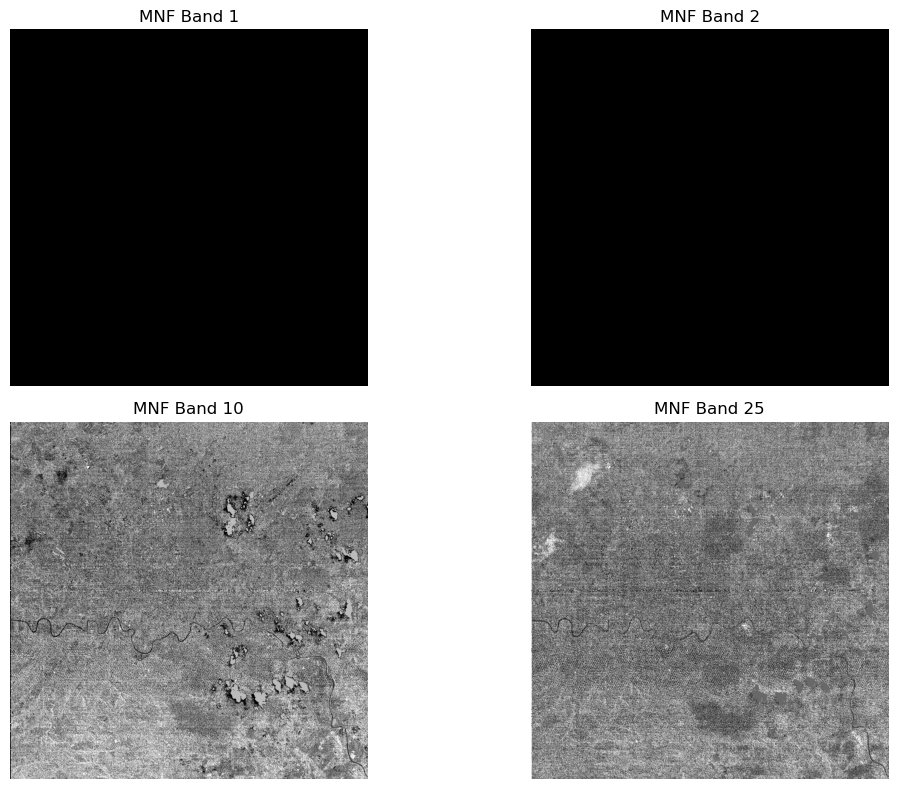

In [2]:
#  MNF Visualize
import numpy as np
import matplotlib.pyplot as plt

mnf = np.load("/home/daljit/hyperspec_project/mnf_cube.npy")

print("MNF cube shape:", mnf.shape)
print("Min:", mnf.min(), "Max:", mnf.max())


mnf = np.load("/home/daljit/hyperspec_project/mnf_cube.npy")

bands_to_show = [0, 1, 9, 24]  # MNF-1, 2, 10, 25

plt.figure(figsize=(12, 8))

for i, b in enumerate(bands_to_show):
    plt.subplot(2, 2, i + 1)
    img = mnf[:, :, b]

    plt.imshow(img, cmap="gray",
               vmin=np.percentile(img, 2),
               vmax=np.percentile(img, 98))
    plt.title(f"MNF Band {b+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()



In [3]:
# MNF to Geotiff
import numpy as np
from osgeo import gdal

# -----------------------------
# 1. Load MNF cube
# -----------------------------
mnf = np.load("/home/daljit/hyperspec_project/mnf_cube.npy")
print("MNF cube:", mnf.shape)

# Select first 10 MNF bands
mnf_sel = mnf[:, :, :10]
rows, cols, bands = mnf_sel.shape

# -----------------------------
# 2. Open reference GeoTIFF
# -----------------------------
ref_ds = gdal.Open("/home/daljit/hyperspec_project/geocorrected.tif")
geotransform = ref_ds.GetGeoTransform()
projection = ref_ds.GetProjection()

# -----------------------------
# 3. Create output GeoTIFF
# -----------------------------
driver = gdal.GetDriverByName("GTiff")
out_ds = driver.Create(
    "/home/daljit/hyperspec_project/mnf_geotiff.tif",
    cols,
    rows,
    bands,
    gdal.GDT_Float32
)

out_ds.SetGeoTransform(geotransform)
out_ds.SetProjection(projection)

# -----------------------------
# 4. Write bands
# -----------------------------
for i in range(bands):
    band = out_ds.GetRasterBand(i + 1)
    band.WriteArray(mnf_sel[:, :, i])
    band.SetDescription(f"MNF Band {i+1}")
    band.FlushCache()

out_ds.FlushCache()
out_ds = None

print("MNF GeoTIFF saved successfully!")


MNF cube: (1000, 1000, 30)


/home/daljit/miniconda3/envs/hypenv/lib/python3.11/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


MNF GeoTIFF saved successfully!


MNF cube: (1000, 1000, 30)


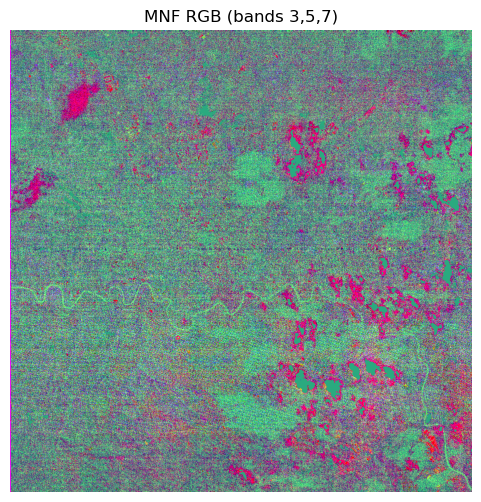

In [ ]:
# MNF RGB
import numpy as np
import matplotlib.pyplot as plt

# Load MNF cube
mnf = np.load("mnf_cube.npy")   # (rows, cols, bands)
print("MNF cube:", mnf.shape)

# Select MNF bands (0-based indexing)
r = mnf[:, :, 2]
g = mnf[:, :, 4]
b = mnf[:, :, 6]

# Stack RGB
rgb = np.stack((r, g, b), axis=2)

# Stretch function
def stretch(img, pmin=2, pmax=98):
    lo, hi = np.percentile(img, (pmin, pmax))
    return np.clip((img - lo) / (hi - lo), 0, 1)

# Apply stretch
rgb_stretched = np.zeros_like(rgb)
for i in range(3):
    rgb_stretched[:, :, i] = stretch(rgb[:, :, i])

# Show in notebook 👇
plt.figure(figsize=(6, 6))
plt.imshow(rgb_stretched)
plt.axis("off")
plt.title("MNF RGB (bands 3,5,7)")
plt.show()

# Save image
plt.imsave("mnf_rgb.png", rgb_stretched)
